In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta
from time import time

Read in the processed data (generated by the pre-processing class)

In [2]:
path=os.getcwd()+"\\data\\home_insurance_processed.csv"
df_updated=pd.read_csv(path)

Convert the date columns to datetime format

In [3]:
df_updated['COVER_START']=pd.to_datetime(df_updated['COVER_START'], format='%d/%m/%Y')
df_updated['P1_DOB']=pd.to_datetime(df_updated['P1_DOB'], format='%d/%m/%Y')

Sort by cover start date

In [4]:
df_updated=df_updated.sort_values('COVER_START')

# Spec the feature columns

In [5]:
df_features=df_updated.drop('is_lapsed', axis=1)

In [6]:
uniques=[df_features[col].nunique() for col in df_features.columns]

In [7]:
def is_categorical_variable(values):
    is_cat=False
    first_valid_index=values.first_valid_index()
    if type(values[first_valid_index]) == str:
        is_cat=True
    return is_cat    

In [8]:
categoricals=[is_categorical_variable(df_features[col]) for col in df_features.columns]

In [9]:
def get_feature_des(col, is_cat):
    values=df_features[col].copy()
    if is_cat:
        des=list(set(values))
    else:
        try:
            des=np.max(values), np.min(values), np.median(values)
        except: #dates
            sorted_dates=sorted(values)
            des=sorted_dates[0], sorted_dates[-1], sorted_dates[len(sorted_dates)//2]
    return des

In [10]:
df_feature_spec=pd.DataFrame({'features':df_features.columns, 'is_categorical': categoricals, 'num_uniques': uniques})
df_feature_spec['des']=[get_feature_des(x, y) for x,y in zip(df_feature_spec['features'], df_feature_spec['is_categorical'])]

In [11]:
pd.set_option('display.max_colwidth', None)
df_feature_spec

,features,is_categorical,num_uniques,des
0,COVER_START,False,2207,"(1992-11-05 00:00:00, 2012-01-30 00:00:00, 2008-12-26 00:00:00)"
1,CLAIM3YEARS,True,2,"[N, Y]"
2,P1_EMP_STATUS,True,11,"[V, S, C, N, U, F, A, R, H, E, I]"
3,BUS_USE,True,2,"[N, Y]"
4,AD_BUILDINGS,True,2,"[N, Y]"
5,SUM_INSURED_BUILDINGS,False,2,"(1000000.0, 0.0, 1000000.0)"
6,NCD_GRANTED_YEARS_B,False,10,"(9.0, 0.0, 6.0)"
7,AD_CONTENTS,True,2,"[N, Y]"
8,RISK_RATED_AREA_C,False,49,"(98.0, 0.0, nan)"
9,SUM_INSURED_CONTENTS,False,11,"(100000.0, 0.0, 50000.0)"


Get the mix of categorical and numerical features: how homogenous is the dataset?

In [12]:
df_feature_spec['is_categorical'].value_counts()

True     35
False    21
Name: is_categorical, dtype: int64

# Feature analysis

i seems to be an series index and policy number unlikely to have any predictive value, so dropping these

In [13]:
df_updated.drop(['i', 'Police'], axis=1, inplace=True)

Transforming the date features

In [14]:
df_updated['cover_start_year']=[x.year for x in df_updated['COVER_START']]
df_updated['cover_start_month']=[x.month for x in df_updated['COVER_START']]
df_updated['age_at_cover_start']=[round((x-y)/np.timedelta64(1, 'Y'),0) for x,y in zip(df_updated['COVER_START'], df_updated['P1_DOB'])]

We can now drop the original date features

In [15]:
df_updated.drop(['COVER_START', 'P1_DOB'], axis=1, inplace=True)

# Policy issuance and lapse over time: is there a trend here?

In [16]:
df_lapse_profile=df_updated[['cover_start_year', 'cover_start_month', 'age_at_cover_start', 'is_lapsed']].copy()

In [17]:
df_lapse_trend=df_lapse_profile.groupby('cover_start_year').agg({'is_lapsed': np.sum, 'cover_start_month': np.size}).reset_index().rename(columns={'is_lapsed': 'num_lapsed', 'cover_start_month': 'num_policies'})
df_lapse_trend['lapse_ratio']=[round(x/y,2) for x,y in zip(df_lapse_trend['num_lapsed'], df_lapse_trend['num_policies'])]
df_lapse_trend['yoy_change_num_policies']=df_lapse_trend['num_policies'].pct_change()
df_lapse_trend

,cover_start_year,num_lapsed,num_policies,lapse_ratio,yoy_change_num_policies
0,1992,7,48,0.15,NaN
1,1993,18,170,0.11,2.541667
2,1994,42,499,0.08,1.935294
3,1995,66,639,0.10,0.280561
4,1996,97,723,0.13,0.131455
5,1997,262,1907,0.14,1.637621
6,1998,473,3233,0.15,0.695333
7,1999,618,3942,0.16,0.219301
8,2000,883,5192,0.17,0.317098
9,2001,953,5244,0.18,0.010015


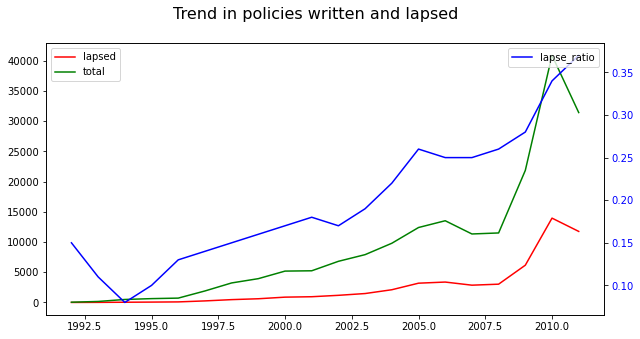

In [18]:
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(10)

fig.suptitle('Trend in policies written and lapsed', fontsize=16)

ax.plot(df_lapse_trend['cover_start_year'][:-1], df_lapse_trend['num_lapsed'][:-1], color = 'red', label = 'lapsed')
ax.plot(df_lapse_trend['cover_start_year'][:-1], df_lapse_trend['num_policies'][:-1], color = 'green', label = 'total')

ax2 = ax.twinx()
ax2.plot(df_lapse_trend['cover_start_year'][:-1], df_lapse_trend['lapse_ratio'][:-1], color='blue', label ='lapse_ratio')
ax2.tick_params(axis='y', labelcolor='blue')

ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
plt.show()

The total number of policies and lapses are increasing over time. <br>Interesting to see that the lapse ratio is increasing over time, as well. <br> Taking a look at the yoy change in policies written

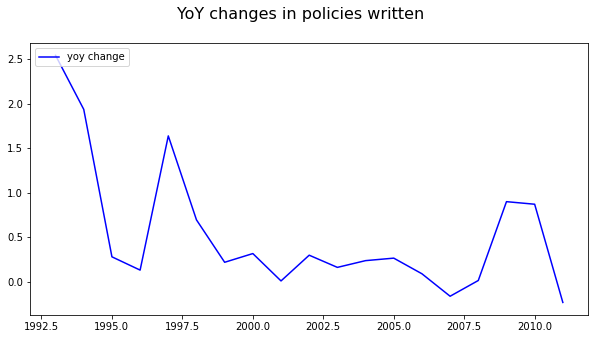

In [19]:
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(10)

fig.suptitle('YoY changes in policies written', fontsize=16)

ax.plot(df_lapse_trend['cover_start_year'][1:-1], df_lapse_trend['yoy_change_num_policies'][1:-1], color = 'blue', 
        label = 'yoy change')

ax.legend(loc = 'upper left')
plt.show()

Bump in policies written in 2009-10 and then a decline in 2011. <br> 
Lapse-ratio, which has been creeping up, gets a bump in 2010-11 to over 30%. <br>
Suggests a structural break around the time of the financial crisis (end-2008) <br>
Will try pre- and post-break cross-validation: will compare models to see if test-set accuracy holds up pre- and post- break and how stable the feature importances are.

# Policy seasonality

In [20]:
df_lapse_seasonality=df_lapse_profile.groupby('cover_start_month').agg({'is_lapsed': np.sum, 'cover_start_year': np.size}).reset_index().rename(columns={'is_lapsed': 'num_lapsed', 'cover_start_year': 'num_policies'})
df_lapse_seasonality['lapse_ratio']=[round(x/y,2) for x,y in zip(df_lapse_seasonality['num_lapsed'], df_lapse_seasonality['num_policies'])]

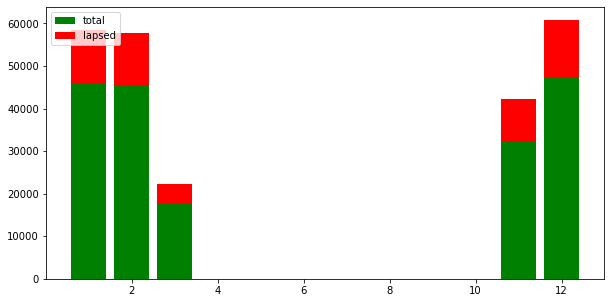

In [21]:
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(10)

ax.bar(df_lapse_seasonality['cover_start_month'], df_lapse_seasonality['num_policies'], color = 'green', label = 'total')
ax.bar(df_lapse_seasonality['cover_start_month'], df_lapse_seasonality['num_lapsed'], bottom= df_lapse_seasonality['num_policies'], color = 'red', label = 'lapsed')

ax.legend(loc = 'upper left')
plt.show()

Most policies seem to be taken out at the beginning of the year and at the end of the year. <br> Not much variation in lapse ratio

# Age distribution of policy holders

<AxesSubplot:>

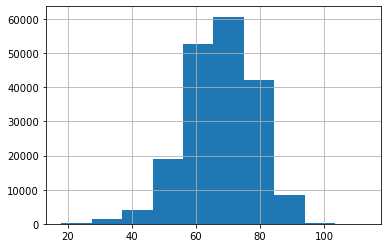

In [22]:
df_updated['age_at_cover_start'].hist()

Preponderance of old people with a median of age ~70

More feature distributions can be plotted and analysed given time. <br>


We'll write out the training dataset and then proceed to model selection and feature importances.

In [ ]:
df_updated.set_index('is_lapsed').to_csv(os.getcwd()+"\\data\\home_insurance_training.csv")